<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objectives
- To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
- To understand the importance of a complex loss function.
- To see how we can optimize not only over network parameters, but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving hannah_close.jpg to hannah_close.jpg

Upload Style Image


Saving monalisa.jpg to monalisa.jpg
Content Path: <_io.BytesIO object at 0x7f2fb16e82f0>
Style Path: <_io.BytesIO object at 0x7f2e9a010fb0>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


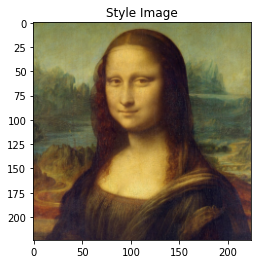

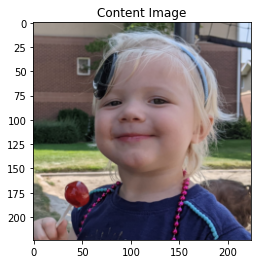

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a network instance to extract the layers needed for statistics

**TODO:**

* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer
content_inds = [vgg_names.index("conv4_2")]
style_inds = [vgg_names.index("conv1_1"),
              vgg_names.index("conv2_1"),
              vgg_names.index("conv3_1"),
              vgg_names.index("conv4_1"),
              vgg_names.index("conv5_1")]


# Create the vgg network in eval mode (I think it's already in eval mode)
style_net =  VGGIntermediate(style_inds).cuda()
content_net = VGGIntermediate(content_inds).cuda()

#  with our forward method that returns the outputs of the intermediate layers we requested

# Cache the outputs of the content and style layers for their respective images
style_layers = style_net(style_image)
content_layers = content_net(content_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
print(len(content_layers))
print(len(style_layers))

1
5


___

### Part 2
Create modules for the style and content loss

Note: You may want to try part 4 before implementing the losses to ensure you understand how style transfer loss works.

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the object
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the object

**DONE:**


In [ ]:
content_layers[19].shape #batch, channel, height, width
content_layers[19].view(1*512, 28*28).shape

torch.Size([512, 784])

In [ ]:
def gram_matrix(input):
    '''
    Input is a feature map from a specific layer. 
    Flattening each tensor into a vector of height*width (with channels depth)
    and then dotting it with itself gives a measure of how similar
    the two feature maps are. 
    '''
    batch, channel, height, width = input.shape
    flat_map = input.view(batch*channel, height*width)
    gram = flat_map @ torch.t(flat_map)
    return gram
  
class ContentLoss(nn.Module):
    def __init__(self, idxs, content_img):
        super(ContentLoss, self).__init__()
        self.vgg = VGGIntermediate(idxs).cuda()
        content_activations = self.vgg(content_img)

        #save content image activations as member var
        self.P = [] #P defined in eq 1 in paper
        for key in content_activations.keys():
            self.P.append(content_activations[key].detach())

    def forward(self, x):
        out_activations = self.vgg(x)
        loss = 0
        #for each layer, sum up difference between
        # output image feature map and the content image feature map
        for l, key in enumerate(out_activations.keys()):
            Fl = out_activations[key]
            loss += torch.sum((Fl - self.P[l])**2)
        loss *= 0.5
        return loss
    
class StyleLoss(nn.Module):
    def __init__(self, idxs, style_img):
        super(StyleLoss, self).__init__()
        self.vgg = VGGIntermediate(idxs).cuda()
        style_activations: dict = self.vgg(style_img)

        #G gram matrix for each layer
        self.g = []
        for key in style_activations.keys():
            Fl = style_activations[key].detach()
            self.g.append(gram_matrix(Fl))

    def forward(self, x):
        out_activations: dict = self.vgg(x)
        loss = 0
        for l, key in enumerate(out_activations.keys()):
            G = gram_matrix(out_activations[key])
            loss += F.mse_loss(G, self.g[l])
        return loss

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison
content_obj = ContentLoss(content_inds, content_image)

# Instantiate a style loss module for each style layer 
#  with the style reference image outputs for that layer for comparison
style_obj = StyleLoss(style_inds, style_image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



epoch:1.000, loss:2082373376.000:   0%|                             | 2/500 [00:00<01:05,  7.59it/s]



Content Loss:0.0, Style Loss:63724164.0


epoch:51.000, loss:9033225.000:  10%|███                           | 52/500 [00:07<01:03,  7.06it/s]



Content Loss:3910059.0, Style Loss:5474789.5


epoch:101.000, loss:4295014.500:  20%|█████▋                      | 102/500 [00:14<00:56,  7.02it/s]



Content Loss:1976599.25, Style Loss:2343830.75


epoch:151.000, loss:3578817.750:  30%|████████▌                   | 152/500 [00:21<00:49,  7.01it/s]



Content Loss:1730627.0, Style Loss:1849450.875


epoch:201.000, loss:3292555.000:  40%|███████████▎                | 202/500 [00:28<00:42,  7.04it/s]



Content Loss:1620740.0, Style Loss:1653850.25


epoch:251.000, loss:3191577.250:  50%|██████████████              | 252/500 [00:35<00:35,  7.00it/s]



Content Loss:1625961.375, Style Loss:1610128.0


epoch:301.000, loss:4123445.500:  60%|████████████████▉           | 302/500 [00:42<00:27,  7.08it/s]



Content Loss:2638779.75, Style Loss:1793068.5


epoch:351.000, loss:6144975.000:  70%|███████████████████▋        | 352/500 [00:50<00:21,  6.98it/s]



Content Loss:3187581.0, Style Loss:2507234.5


epoch:401.000, loss:7755038.000:  80%|██████████████████████▌     | 402/500 [00:57<00:14,  7.00it/s]



Content Loss:3500969.75, Style Loss:4253131.0


epoch:451.000, loss:5390592.000:  90%|█████████████████████████▎  | 452/500 [01:04<00:06,  7.05it/s]



Content Loss:2799569.0, Style Loss:2822962.75


epoch:499.000, loss:7433776.000: 100%|████████████████████████████| 500/500 [01:11<00:00,  7.03it/s]


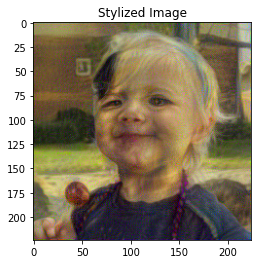

In [ ]:
# Start with a copy of the content image
img = content_image.clone()

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors

#note that I start with a copy of the content image instead of white noise. 
optimizer = optim.Adam([img.requires_grad_()], lr=0.1)

losses = []
alpha = 1.0
beta = .01
num_epochs = 500
loop = tqdm(total=num_epochs, position=0, ncols=100, leave=True)
for epoch in range(num_epochs):
    optimizer.zero_grad()

    content_loss = content_obj(img) * alpha 
    style_loss = style_obj(img) * beta
    loss = style_loss + content_loss

    losses.append(loss.item())

    loop.set_description("epoch:{:.3f}, loss:{:.3f}".format(epoch, loss.item()))
    loop.update(1)

    if epoch % 50 == 0:
        print("\n\nContent Loss:{}, Style Loss:{}".format(content_loss.item(), style_loss.item()))

    loss.backward()
    optimizer.step()

    img.data.clamp_(0,1)

loop.close()

# Show the image
plt.figure()
display(img, title='Stylized Image')

## Observations of Results

Does a decent job of capturing color pallete. Does some weird shaping things with facial features, most noticably the eyes. The right eye is much larger. 

Also notice the "smoky" sfumato texture so characteristic of DaVinci's art. But the DNN makes it look a bit grainy, which is interesting. Changing hyperparams didn't seem to ever change this. This is because (you can't really see this on the printed out MonaLisa in the notebook because it's too small) the image of the mona lisa that I downloaded is wrinkled and cracked -- presumably from age. Its cool that the DNN picked up on this, even though not explicitly part of DaVinci's 'style'.

### Part 4

Show that you understand style transfer by describing the key equations of (Gatys 2016) in your own words.

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

### Equation 1
Equation 1 in the paper is the content loss. Itis the squared error loss over $F$ (the output image feature map) and $P$ (the photograph or content image feature map). $i$ represents the ith convolutional filter position of the RGG network at position $j$ in the $l$th layer.

### Equation 3
Equation 3 is the gram matrix where $F$ is the output image feature map that has been flattened into an length*width vector. That feature map is then dotted with every other flattened vector corresponding to all of the channels. $l$ again is the CNN layer. $k$ is a summation variable. $i$ and $j$ are positions in each feature map. 

### Equation 4
This is the mean squared error of a layer $l$ between the gram matrix of the output feature map and the art $A$ (or the style image). $N_l$ and $M_l$ are both sizes of the conv filter. $i$ and $j$ are once again positions in that layer.

### Equation 5
Equation 5 is the style loss where $w$ is a weighting factor for each layer's contribution to the total loss and $E$ is the layer $l$'s contribution of error. 